# Setup

In [1]:
from huggingface_hub import login, whoami

login()

In [2]:
import pandas as pd
DATASET_PATH = 'derek-thomas/vision-embedding-ie-optimization'
df = pd.read_parquet(f"hf://datasets/{DATASET_PATH}/data/train-00000-of-00001.parquet")

df.columns

Index(['total_requests', 'test_duration_sec', 'successful_requests',
       'avg_latency_ms', 'p95_latency_ms', 'throughput_req_per_sec',
       'avg_num_vectors', 'min_num_vectors', 'max_num_vectors',
       'invalid_embeddings', 'hw_type', 'batch_size', 'image', 'engine',
       'vendor', 'vus', 'seconds_per_billion', 'cost_per_sec', '1B_cost'],
      dtype='object')

# Best Runs

In [3]:
df[['1B_cost', 'hw_type', 'batch_size', 'vus', ]].sort_values(by='1B_cost').head()

1B_cost    hw_type  batch_size  vus
12  44496.514140  nvidia-l4           4    4
2   46021.581982  nvidia-l4           1    4
7   46056.243394  nvidia-l4           2    4
27  46223.463621  nvidia-l4          32    4
17  46293.441279  nvidia-l4           8    4

# Sanity Checks

## Are we getting the expected embedding size?
We have a nice check [here](https://github.com/datavistics/encoder-analysis/blob/b5c43f8de0004d5744b765486ffc92ae94347ce4/templates/vision-embedding-analysis.js.j2#L82-L84) that makes sure that our response is valid, especially the size of the embedding which should be `128`. More formally `invalid_embeddings` tells us the number of requests with a malformed response per run. We should expect to see all values being 0 here. 

Min	0
Max	0


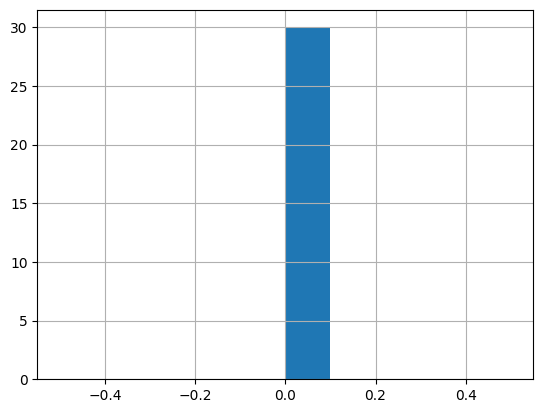

In [4]:
df.invalid_embeddings.hist(bins=10)
print(f"Min\t{df.invalid_embeddings.min()}")
print(f"Max\t{df.invalid_embeddings.max()}")

## Did we have any failed requests?
We should expect to see `0` here if all our requests were successful.

In [5]:
sum(df.total_requests - df.successful_requests)

0

## How many vectors are we getting back?
We are using a ColBERT style model which means we should be getting multiple vectors per image. Its interesting to see the distribution of these as it allows us to check for anything unexpected and to get to know our data. To do so I stored the `min_num_vectors`, `avg_num_vectors`, `max_num_vectors`, in the [experiments](https://github.com/datavistics/encoder-analysis/blob/b5c43f8de0004d5744b765486ffc92ae94347ce4/templates/vision-embedding-analysis.js.j2#L123-L125).

We should expect to see some variance in all 3, but its ok that `min_num_vectors` and `max_num_vectors` have the same value across experiments.

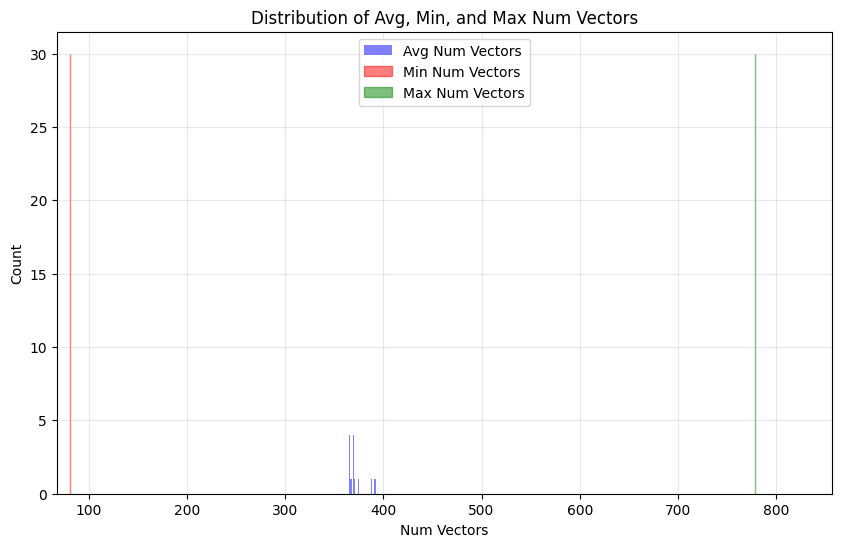

In [6]:
import matplotlib.pyplot as plt

# Create histogram
plt.figure(figsize=(10, 6))

plt.hist(df["avg_num_vectors"], bins=50, alpha=0.5, color='blue', label="Avg Num Vectors")
plt.hist(df["min_num_vectors"], bins=50, alpha=0.5, edgecolor='red', color='red', label="Min Num Vectors")
plt.hist(df["max_num_vectors"], bins=50, alpha=0.5, edgecolor='green', color='green', label="Max Num Vectors")

# Extend x-axis to ensure max is visible
plt.xlim(df["min_num_vectors"].min() / 1.2, df["max_num_vectors"].max() * 1.1)

# Labels & legend
plt.title("Distribution of Avg, Min, and Max Num Vectors")
plt.xlabel("Num Vectors")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)

# Show plot
plt.show()


## Did we try enough VUs?
How do we know that we tried enough VUs? What if we tried a higher amount of VUs and throughput kept increasing? If thats the case then we would see a monotonicly increasing relationship between VUs and Throughput and we would need to run more tests. Lets check this out!

We can check by:
1. **Grouping data** by `hw_type` and `batch_size` to match how we generated the experiments
1. **Sorting the data** by `vus` within each group to ensure we get the data in the correct order for our check
1. **Check for monotonic increase** in `throughput_req_per_sec` flag the groups that always increase throughput as VUs increase


Note: do a sanity check with the following code to make sure that this does indeed detect if it does in-fact detect the series you expect.
```python
df_filtered = df[df['vus'] <= 256]`
grouped = df_filtered.groupby(['hw_type', 'batch_size'])
```


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping by 'hw_type' and 'batch_size'
grouped = df.groupby(['hw_type', 'batch_size'])

# Identifying monotonically increasing series for throughput_req_per_sec as vus increases
monotonic_series = {}
for (hw_type, batch_size), group in grouped:
    group_sorted = group.sort_values('vus')  # Ensure sorted order by vus
    if group_sorted['throughput_req_per_sec'].is_monotonic_increasing:
        monotonic_series[(hw_type, batch_size)] = group_sorted[['vus', 'throughput_req_per_sec']]

# Plotting the identified monotonically increasing series
for (hw_type, batch_size), data in monotonic_series.items():
    plt.figure(figsize=(8, 5))
    plt.plot(data['vus'], data['throughput_req_per_sec'], marker='o', linestyle='-')
    plt.xlabel('Virtual Users (VUs)')
    plt.ylabel('Throughput (Requests per Sec)')
    plt.title(f'Throughput Trend for HW: {hw_type}, Batch: {batch_size}')
    plt.grid(True)
    plt.show()

# Display the results in a DataFrame
monotonic_df = pd.DataFrame(
    [(hw, batch) for (hw, batch) in monotonic_series.keys()],
    columns=['hw_type', 'batch_size']
)

print(monotonic_df)


Empty DataFrame
Columns: [hw_type, batch_size]
Index: []


# Analysis

## 1B Cost vs. Latency Scatter Plot

This chart visualizes the daily cost per billion requests (`1B_cost`) against average latency (`avg_latency_ms`), highlighting optimal configurations across different hardware types, batch sizes, and performance metrics.

### How to Read the Chart:
- **Scatter Points**: Each point represents a configuration. 
  
- **Red Star**: This marker identifies the configuration with the lowest daily cost, making it easy to spot the most cost-effective option.
  
- **Red Dashed Line (Pareto Front)**: This line connects the Pareto-efficient configurations—those offering the best trade-offs between cost and latency, where improving one metric would worsen the other.

### How to Use:
- **Identify Optimal Configurations**: Focus on the **red star** for the lowest cost and follow the **Pareto front** to see the best trade-offs between cost and latency.
  
- **Compare Configurations**: Use the **scatter points** and **hover details** to compare different hardware types, batch sizes, and performance metrics, aiding in decision-making based on your priorities.
  
- **Assess Trade-offs**: The **Pareto front** helps you understand which configurations provide the most balanced performance, ensuring cost efficiency without compromising latency.


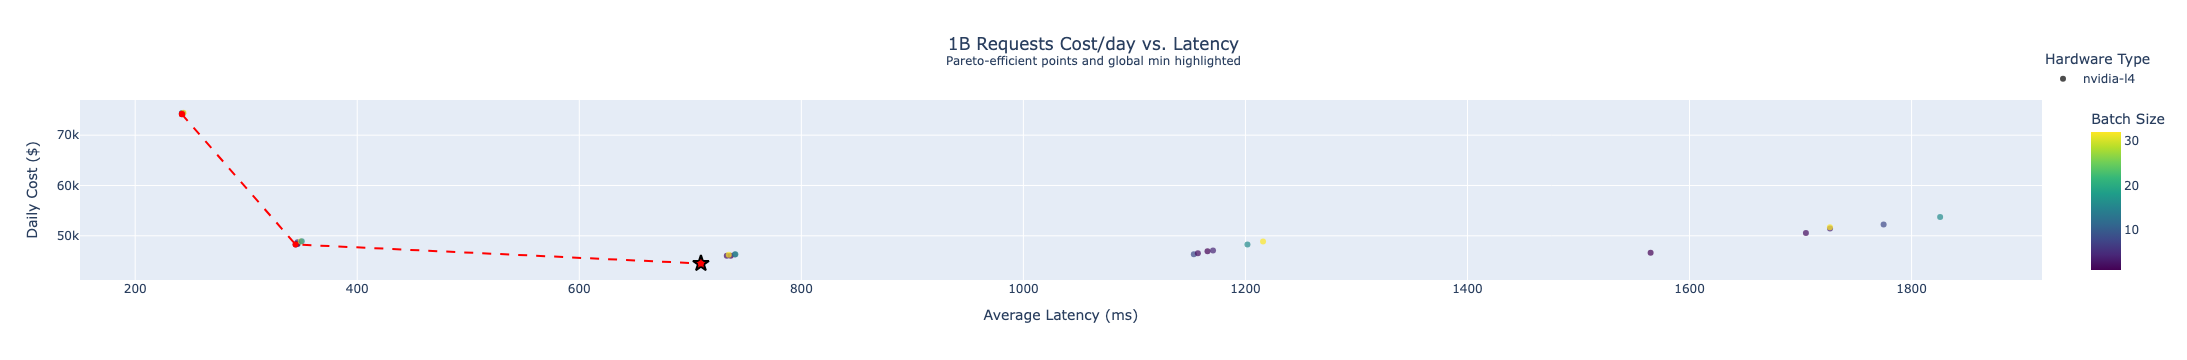

In [8]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Get the 100 lowest-cost points
bottom_100 = df.nsmallest(500, "1B_cost").copy()
bottom_100["1B_cost"] = bottom_100["1B_cost"].round(2)
bottom_100["throughput_req_per_sec"] = bottom_100["throughput_req_per_sec"].round(2)
bottom_100["avg_latency_ms"] = bottom_100["avg_latency_ms"].round(3)

# Find the global minimum cost point *only within* the bottom 100 points
global_min = bottom_100.nsmallest(1, "1B_cost")

# Function to find Pareto-efficient points (minimizing cost and latency)
def pareto_efficient(df, x_col, y_col):
    sorted_df = df.sort_values(by=[x_col, y_col])  # Sort by latency, then cost
    pareto_points = []
    min_cost = np.inf  # Start with a very high cost
    
    for _, row in sorted_df.iterrows():
        if row[y_col] < min_cost:  # If this cost is the lowest seen so far
            pareto_points.append(row)
            min_cost = row[y_col]
    
    return pd.DataFrame(pareto_points)

# Compute Pareto front
pareto_front = pareto_efficient(bottom_100, "avg_latency_ms", "1B_cost")

# Base scatter plot (showing 100 lowest-cost points)
fig = px.scatter(
    bottom_100, 
    x="avg_latency_ms", 
    y="1B_cost", 
    symbol="hw_type", 
    color="batch_size",  
    color_continuous_scale="viridis",  
    opacity=0.7, 
    title="1B Requests Cost/day vs. Latency<br><sup>Pareto-efficient points and global min highlighted</sup>",
    labels={
        "avg_latency_ms": "Average Latency (ms)",
        "1B_cost": "Daily Cost ($)",
        "hw_type": "Hardware Type",
        "batch_size": "Batch Size",
    },
    hover_data=["vus", "batch_size", "throughput_req_per_sec"]
)

# Add global minimum cost point (red star)
fig.add_trace(
    go.Scatter(
        x=global_min["avg_latency_ms"],
        y=global_min["1B_cost"],
        mode="markers",
        marker=dict(size=12, color="red", symbol="star", line=dict(width=2, color="black")),
        name="Global Min Cost",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=global_min["batch_size"],
        customdata=global_min[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Add Pareto curve with detailed hover info
fig.add_trace(
    go.Scatter(
        x=pareto_front["avg_latency_ms"],
        y=pareto_front["1B_cost"],
        mode="lines+markers",
        line=dict(color="red", width=2, dash="dash"),
        marker=dict(size=6, color="red"),
        name="Pareto Front",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=pareto_front["batch_size"],
        customdata=pareto_front[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Adjust layout (Center title)
fig.update_layout(
    title_x=0.5,  # Centers title
    legend=dict(
        x=1,  
        y=1.3,  
        title="Hardware Type"
    )
)

fig.show()


## Cost vs VUs and Batch Size Contour Plots

These contour plots visualize the cost per billion requests (`1B_cost`) as a function of **VUs (Virtual Users)** and **Batch Size** for different hardware configurations (`hw_type`) and image types (`image`).

### How to Read the Charts:
- **Color Gradient**: Shows the cost levels, with darker colors representing higher costs and lighter colors representing lower costs.
- **Contour Lines**: Represent cost levels, helping identify cost-effective regions.
- **White Dots**: Represent real data points used to generate the interpolated surface.
- **Red Stars**: Highlight the lowest cost point in the dataset.
- **Small Red Dots**: Indicate the lowest cost for each batch size.

### How to Use:
- Identify the **lowest cost configurations** (red stars and dots).
- Observe how **cost changes** with batch size and VUs to optimize your setup.

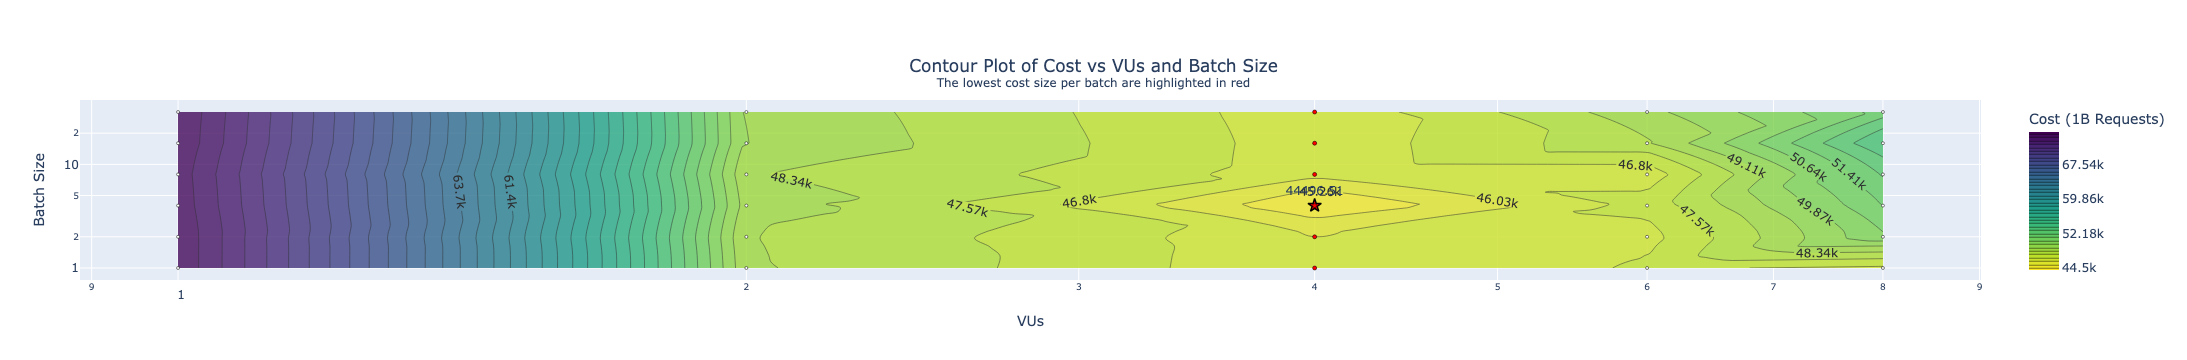

In [9]:
import plotly.graph_objects as go
import scipy.interpolate
import numpy as np
import pandas as pd
import base64
import json

# Define percentile bins for cost
percentiles = np.linspace(0, 100, 40)  # Define bins using percentiles
cost_bins = np.percentile(df["1B_cost"], percentiles)  # Compute cost bins

# Create grid for interpolation (Now X = VUs, Y = batch_size)
grid_x_real, grid_y_real = np.meshgrid(
    np.linspace(df["vus"].min(), df["vus"].max(), 100),  # X-axis is now VUs
    np.linspace(df["batch_size"].min(), df["batch_size"].max(), 100)  # Y-axis is now batch_size
)

# Interpolate cost data (Now X = VUs, Y = batch_size)
grid_z_real = scipy.interpolate.griddata(
    (df["vus"], df["batch_size"]),  # Order remains the same
    df["1B_cost"],
    (grid_x_real, grid_y_real),  # Adjusted grid order
    method='linear'  # Linear interpolation for smoother transitions
)

# Identify the 5 lowest cost points
lowest_cost_points = df.nsmallest(1, "1B_cost")

# Identify the minimum cost point for each batch size
min_per_batch = df.loc[df.groupby("batch_size")["1B_cost"].idxmin()]

# Create Plotly figure
fig = go.Figure()

# Contour plot with percentile-based cost bins
fig.add_trace(
    go.Contour(
        z=grid_z_real,
        x=np.linspace(df["vus"].min(), df["vus"].max(), 100),  # X-axis is now VUs
        y=np.linspace(df["batch_size"].min(), df["batch_size"].max(), 100),  # Y-axis is now batch_size
        colorscale="viridis_r",
        contours=dict(
            start=cost_bins[0],
            end=cost_bins[-1],
            size=np.diff(cost_bins).mean(),  # Uses percentile bins
            showlabels=True
        ),
        colorbar=dict(title="Cost (1B Requests)"),
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{z}",
        opacity=0.8  # Reduce opacity to make scatter points stand out
    )
)

# Scatter plot of actual data points
fig.add_trace(
    go.Scatter(
        x=df["vus"],  # X-axis is now VUs
        y=df["batch_size"],  # Y-axis is now batch_size
        mode="markers",
        marker=dict(size=3, color="white", line=dict(width=0.5, color="black")),  
        name="Real Data Points",
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
        text=df["1B_cost"].round(2),
        showlegend=False
    )
)

# Scatter plot for lowest global cost points (Red Stars)
fig.add_trace(
    go.Scatter(
        x=lowest_cost_points["vus"],
        y=lowest_cost_points["batch_size"],
        mode="markers+text",
        marker=dict(size=10, color="red", symbol="star", line=dict(width=1.5, color="black")),
        name="Lowest 5 Cost Points",
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
        text=lowest_cost_points["1B_cost"].round(2),
        textposition="top center",
        showlegend=False
    )
)

# Scatter plot for minimum cost per batch size (Small Red Dots)
fig.add_trace(
    go.Scatter(
        x=min_per_batch["vus"],
        y=min_per_batch["batch_size"],
        mode="markers",
        marker=dict(size=4, color="red", line=dict(width=0.5, color="black")),
        name="Min Cost per Batch Size",
        hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
        text=min_per_batch["1B_cost"].round(2),
        showlegend=False
    )
)

fig.update_layout(
    title=f"Cost vs VUs and Batch Size",
    xaxis_title="VUs",
    yaxis_title="Batch Size",
    xaxis_type="log",
    yaxis_type="log"
)

fig.update_layout(
title={
    "text": f"Contour Plot of Cost vs VUs and Batch Size<br><sup>The lowest cost size per batch are highlighted in red</sup>",
    "x": 0.5,  # Center align
    "y": 0.8,  # Adjust vertical position
}
)